# Gromore basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib as mp
import os
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#print full output
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

#Delete Packages
# dir = "/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/GroMore_Project/amanda/scenario2"
# dir = "C:\Users\vivek\Documents\UA Coursework\HWRS 582 Groundwater Modelling\GroMore_Project\Vivek\Scenario 1"
# dir = "/Users/hardknox47/Desktop/HWRS482/hw482/GroMore_Project/Justin"

# files = os.listdir(dir)
# ext=['.dis','.bas','.lpf','.oc','.pcg','.wel','.hds','.cbc','.riv','.list','.nam','.evt',
#      '.rch','.mpbas','.mpend','.mplst','.mpnam','.mppth','.mpsim','.log','.timeseries',
#      '.lis','.chd','.ddn','.sloc']
# for file in files:
#     for i in range(0,len(ext)):
#         if file.endswith(ext[i]):
#             os.remove(os.path.join(dir,file))

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/flopy


## 2. Discretization and other inputs

In [2]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)
ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 

rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

extinction_depth = 10 #m

## Recharge
rech=4e-5  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

rech_zone = np.zeros((1,nrow,ncol))
rech_zone[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
#print("recharge location forced(col, row)", rech_cols_forced,rech_rows_forced)

# Setting up wells
pumping1 = 0 # m3/day      -1500 pumping rate for water supply well  
pumping2 = 0 # m^3/d         -3000 irrigation well pumping rate (for wheat)

well_agua = [2,29,37, pumping1] #Well loc (layer, row, column)
well_ag = [0,38,12, pumping2] #Well loc (layer, row, column)
MW1 = [0,25,24,0]
MW2 = [0,37,12,0]

wel_spd = {0: [well_agua, well_ag, MW1, MW2]}

## init boundary conditions
h_right = 70

### Layering

In [3]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 

## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 

## Boundary Conditions

In [4]:
#setup initial heads as the end of scenario 2 burn in values (after 200 years w. seasonality)

H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[0, :, :] = np.genfromtxt('top_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the top layer with 200 yr burn in vals
H_init[1, :, :] = np.genfromtxt('mid_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the mid layer with 200 yr burn in vals
H_init[2, :, :] = np.genfromtxt('bot_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the bottom layer with 200 yr burn in vals

#Adding no flow boundaries
#########################

# Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  # 1st col = no flow       
ibound[:,:,49] = -1  # last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

In [5]:
#Testing the read in boundaries 
#Getting final heads
print("Final Head at Monitoring Well 2 = ", H_init[0, 37, 12])
print("Final Head at Monitoring Well 1 = ", H_init[0, 25, 24])
print("Final Head at Community Well 1 = ", H_init[2, 29, 37])

Final Head at Monitoring Well 2 =  90.759125
Final Head at Monitoring Well 1 =  78.6153
Final Head at Community Well 1 =  73.889595


## River Properties

In [6]:
#DEFINE RIVERS
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#create dictionary of stress period data
riv_spd = {0: riv_sp}

# Scenario 4: Post development with seasonality, future projection
Project your post-development model with seasonality an additional 100 years into the future. (Remember to project the town's water demand, too!)

Compare this model with your pre-development model with seasonality.
How can you quantify the impacts of the town's water extraction on the hydrologic system? Describe your metrics as precisely as you can and quantify the impact(s).

### Setting up seasonality


In [7]:
#We start in October, because that's a water year
sp_peryr = 2        # periods for seasonality (two stress periods per year)
sp1_len = 180       # Length of stress period 1 in days, October-March, no ET
sp2_len = 180      # Length of stress period 2 in days. April - September, regular ET
sim_years = 100       #number of years for transient simulation 
#nper = int(sp_peryr*sim_years + 1) # 201
nper = int(sp_peryr*sim_years)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False # transient flag is false
#steady[0] = True    # initial stress period is steady-state or true

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)#100 repeating sets of the two stress periods
#perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen*1  
#nstp[0]=1 #for the steady state solution we just want one output

### Setting up seasonal ET

In [8]:
#Setup alternating ET values
#ET_zone has the seasonal ET values
                      
ET_dict = {} #set up an ET dictionary, where each key is a stress period num 0-50
ET_zone2 = ET_zone * 0 
# for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
#     if p == 0:
#         ET_dict[p] = ET_zone
#     elif int(p % 2) != 0:
#         ET_dict[p]=ET_zone2
#         #print(p)
#     else: 
#         ET_dict[p] = ET_zone

#No steady state test
for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    if p == 0:
        ET_dict[p] = ET_zone2
    elif int(p % 2) != 0:
        ET_dict[p]=ET_zone
        #print(p)
    else: 
        ET_dict[p] = ET_zone2

## Setting up the post development pumping

In [9]:
#addings these pumping wells for aguaseca community well
pumping_predevel = [2,29,37,0]
pumping0_10 = [2,29,37,-1730]  #post devel pumping rate starts here
pumping10_20 = [2,29,37,-1971]
pumping20_30 = [2,29,37,-2223]
pumping30_40 = [2,29,37,-2484]
pumping40_50 = [2,29,37,-2755]
pumping50_60 =[2,29,37,-3035]
pumping60_70 =[2,29,37,-3324]
pumping70_80 =[2,29,37,-3622]
pumping80_90 = [2,29,37,-3928] 
pumping90_100 = [2,29,37,-4242] #final pumping rate to bring us to present

#Set up the wel data for stress periods, changing well_agua pumping rate
wel_spd = {}  

for p in range(0,nper): #nper = 201
    if p == 0: 
        wel_spd[p]=[pumping0_10, well_ag, MW1, MW2]     
    elif p > 0 and p <= 21:
        wel_spd[p]=[pumping0_10, well_ag, MW1, MW2]
    elif p > 21 and p <= 41:
        wel_spd[p]=[pumping10_20, well_ag, MW1, MW2]
    elif p > 41 and p <= 61:
        wel_spd[p]=[pumping20_30, well_ag, MW1, MW2]
    elif p > 61 and p <= 81:
        wel_spd[p]=[pumping30_40, well_ag, MW1, MW2]
    elif p > 81 and p <= 101:
        wel_spd[p]=[pumping40_50, well_ag, MW1, MW2]
    elif p > 101 and p <= 121:
        wel_spd[p]=[pumping50_60, well_ag, MW1, MW2]
    elif p > 121 and p <= 141:
        wel_spd[p]=[pumping60_70, well_ag, MW1, MW2]
    elif p > 141 and p <= 161:
        wel_spd[p]=[pumping70_80, well_ag, MW1, MW2]
    elif p > 161 and p <= 181:
        wel_spd[p]=[pumping80_90, well_ag, MW1, MW2]
    else:
        wel_spd[p]=[pumping90_100, well_ag, MW1, MW2]
        

In [10]:
print(wel_spd[1])

[[2, 29, 37, -1730], [0, 38, 12, 0], [0, 25, 24, 0], [0, 37, 12, 0]]


## Set up and run scenario 3

In [11]:
#Initialize the model
modelname = "Scenario_4"
#moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
moddir="/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp = nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)

rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object


# Attach ET package
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_dict, exdp=extinction_depth, ipakcb=53) 

wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

#Setting up RIV package
riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)

#Output control - OC 
oc_spd = {}
for kper in range(1,nper): #nper is 201, this is the key for each entry in oc_spd dict
    oc_spd[(kper, 1)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 90)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 179)] = ['save head','save drawdown','save budget','print head','print budget']
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
# pcg = flopy.modflow.ModflowPcg(model=m)
#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=100, iter1=200, relax = 0.97, damp = 0.9)

#write the inputs
m.write_input()   

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Scenario_4.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/23  7:53:13

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn

 Solving:  Stress period:     1    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   117    Ground-Wa

 Solving:  Stress period:     2    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    53    Ground-Wa

 Solving:  Stress period:     2    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   171    Ground-Wa

 Solving:  Stress period:     3    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   103    Ground-Wa

 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    42    Ground-Wa

 Solving:  Stress period:     4    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   164    Ground-Wa

 Solving:  Stress period:     5    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    98    Ground-Wa

 Solving:  Stress period:     6    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    37    Ground-Wa

 Solving:  Stress period:     6    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   159    Ground-Wa

 Solving:  Stress period:     7    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    93    Ground-Wa

 Solving:  Stress period:     8    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    33    Ground-Wa

 Solving:  Stress period:     8    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   155    Ground-Wa

 Solving:  Stress period:     9    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    89    Ground-Wa

 Solving:  Stress period:    10    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    27    Ground-Wa

 Solving:  Stress period:    10    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   147    Ground-Wa

 Solving:  Stress period:    11    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    81    Ground-Wa

 Solving:  Stress period:    12    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    23    Ground-Wa

 Solving:  Stress period:    12    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   142    Ground-Wa

 Solving:  Stress period:    13    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    79    Ground-Wa

 Solving:  Stress period:    14    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    19    Ground-Wa

 Solving:  Stress period:    14    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   136    Ground-Wa

 Solving:  Stress period:    15    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    73    Ground-Wa

 Solving:  Stress period:    16    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    16    Ground-Wa

 Solving:  Stress period:    16    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   130    Ground-Wa

 Solving:  Stress period:    17    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    69    Ground-Wa

 Solving:  Stress period:    18    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    14    Ground-Wa

 Solving:  Stress period:    18    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   126    Ground-Wa

 Solving:  Stress period:    19    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    64    Ground-Wa

 Solving:  Stress period:    19    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     7    Ground-Wa

 Solving:  Stress period:    20    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   120    Ground-Wa

 Solving:  Stress period:    21    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    57    Ground-Wa

 Solving:  Stress period:    21    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   180    Ground-Wa

 Solving:  Stress period:    22    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   115    Ground-Wa

 Solving:  Stress period:    23    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    52    Ground-Wa

 Solving:  Stress period:    23    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   172    Ground-Wa

 Solving:  Stress period:    24    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   106    Ground-Wa

 Solving:  Stress period:    25    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    47    Ground-Wa

 Solving:  Stress period:    25    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   167    Ground-Wa

 Solving:  Stress period:    26    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   100    Ground-Wa

 Solving:  Stress period:    27    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    39    Ground-Wa

 Solving:  Stress period:    27    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   157    Ground-Wa

 Solving:  Stress period:    28    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    92    Ground-Wa

 Solving:  Stress period:    29    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    32    Ground-Wa

 Solving:  Stress period:    29    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   150    Ground-Wa

 Solving:  Stress period:    30    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    86    Ground-Wa

 Solving:  Stress period:    31    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    26    Ground-Wa

 Solving:  Stress period:    31    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   141    Ground-Wa

 Solving:  Stress period:    32    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    77    Ground-Wa

 Solving:  Stress period:    33    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    20    Ground-Wa

 Solving:  Stress period:    33    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   133    Ground-Wa

 Solving:  Stress period:    34    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    71    Ground-Wa

 Solving:  Stress period:    35    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    16    Ground-Wa

 Solving:  Stress period:    35    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   127    Ground-Wa

 Solving:  Stress period:    36    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    67    Ground-Wa

 Solving:  Stress period:    37    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    14    Ground-Wa

 Solving:  Stress period:    37    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   122    Ground-Wa

 Solving:  Stress period:    38    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    60    Ground-Wa

 Solving:  Stress period:    38    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     7    Ground-Wa

 Solving:  Stress period:    39    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   116    Ground-Wa

 Solving:  Stress period:    40    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    54    Ground-Wa

 Solving:  Stress period:    40    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   179    Ground-Wa

 Solving:  Stress period:    41    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   109    Ground-Wa

 Solving:  Stress period:    42    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    48    Ground-Wa

 Solving:  Stress period:    42    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   173    Ground-Wa

 Solving:  Stress period:    43    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   104    Ground-Wa

 Solving:  Stress period:    44    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    42    Ground-Wa

 Solving:  Stress period:    44    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   163    Ground-Wa

 Solving:  Stress period:    45    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    95    Ground-Wa

 Solving:  Stress period:    46    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    35    Ground-Wa

 Solving:  Stress period:    46    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   155    Ground-Wa

 Solving:  Stress period:    47    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    88    Ground-Wa

 Solving:  Stress period:    48    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    28    Ground-Wa

 Solving:  Stress period:    48    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   148    Ground-Wa

 Solving:  Stress period:    49    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    82    Ground-Wa

 Solving:  Stress period:    50    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    22    Ground-Wa

 Solving:  Stress period:    50    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   138    Ground-Wa

 Solving:  Stress period:    51    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    74    Ground-Wa

 Solving:  Stress period:    52    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    16    Ground-Wa

 Solving:  Stress period:    52    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   132    Ground-Wa

 Solving:  Stress period:    53    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    67    Ground-Wa

 Solving:  Stress period:    53    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    12    Ground-Wa

 Solving:  Stress period:    54    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   123    Ground-Wa

 Solving:  Stress period:    55    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    59    Ground-Wa

 Solving:  Stress period:    55    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     4    Ground-Wa

 Solving:  Stress period:    56    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   116    Ground-Wa

 Solving:  Stress period:    57    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    51    Ground-Wa

 Solving:  Stress period:    57    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   167    Ground-Wa

 Solving:  Stress period:    58    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    97    Ground-Wa

 Solving:  Stress period:    59    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    32    Ground-Wa

 Solving:  Stress period:    59    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   145    Ground-Wa

 Solving:  Stress period:    60    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    79    Ground-Wa

 Solving:  Stress period:    61    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    18    Ground-Wa

 Solving:  Stress period:    61    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   126    Ground-Wa

 Solving:  Stress period:    62    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    62    Ground-Wa

 Solving:  Stress period:    62    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     7    Ground-Wa

 Solving:  Stress period:    63    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   113    Ground-Wa

 Solving:  Stress period:    64    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    49    Ground-Wa

 Solving:  Stress period:    64    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   168    Ground-Wa

 Solving:  Stress period:    65    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    96    Ground-Wa

 Solving:  Stress period:    66    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    34    Ground-Wa

 Solving:  Stress period:    66    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   152    Ground-Wa

 Solving:  Stress period:    67    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    82    Ground-Wa

 Solving:  Stress period:    68    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    19    Ground-Wa

 Solving:  Stress period:    68    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   133    Ground-Wa

 Solving:  Stress period:    69    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    67    Ground-Wa

 Solving:  Stress period:    69    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     9    Ground-Wa

 Solving:  Stress period:    70    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   119    Ground-Wa

 Solving:  Stress period:    71    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    55    Ground-Wa

 Solving:  Stress period:    71    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   175    Ground-Wa

 Solving:  Stress period:    72    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   105    Ground-Wa

 Solving:  Stress period:    73    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    41    Ground-Wa

 Solving:  Stress period:    73    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   152    Ground-Wa

 Solving:  Stress period:    74    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    85    Ground-Wa

 Solving:  Stress period:    75    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    23    Ground-Wa

 Solving:  Stress period:    75    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   134    Ground-Wa

 Solving:  Stress period:    76    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    69    Ground-Wa

 Solving:  Stress period:    76    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    12    Ground-Wa

 Solving:  Stress period:    77    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   119    Ground-Wa

 Solving:  Stress period:    78    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    58    Ground-Wa

 Solving:  Stress period:    78    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     2    Ground-Wa

 Solving:  Stress period:    79    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   112    Ground-Wa

 Solving:  Stress period:    80    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    52    Ground-Wa

 Solving:  Stress period:    80    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   174    Ground-Wa

 Solving:  Stress period:    81    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   103    Ground-Wa

 Solving:  Stress period:    82    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    43    Ground-Wa

 Solving:  Stress period:    82    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   166    Ground-Wa

 Solving:  Stress period:    83    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    98    Ground-Wa

 Solving:  Stress period:    84    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    39    Ground-Wa

 Solving:  Stress period:    84    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   156    Ground-Wa

 Solving:  Stress period:    85    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    85    Ground-Wa

 Solving:  Stress period:    86    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    21    Ground-Wa

 Solving:  Stress period:    86    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   138    Ground-Wa

 Solving:  Stress period:    87    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    71    Ground-Wa

 Solving:  Stress period:    87    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    12    Ground-Wa

 Solving:  Stress period:    88    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   120    Ground-Wa

 Solving:  Stress period:    89    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    56    Ground-Wa

 Solving:  Stress period:    89    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   177    Ground-Wa

 Solving:  Stress period:    90    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   111    Ground-Wa

 Solving:  Stress period:    91    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    51    Ground-Wa

 Solving:  Stress period:    91    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   169    Ground-Wa

 Solving:  Stress period:    92    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   101    Ground-Wa

 Solving:  Stress period:    93    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    39    Ground-Wa

 Solving:  Stress period:    93    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   155    Ground-Wa

 Solving:  Stress period:    94    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    88    Ground-Wa

 Solving:  Stress period:    95    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    26    Ground-Wa

 Solving:  Stress period:    95    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   137    Ground-Wa

 Solving:  Stress period:    96    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    73    Ground-Wa

 Solving:  Stress period:    97    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    16    Ground-Wa

 Solving:  Stress period:    97    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   125    Ground-Wa

 Solving:  Stress period:    98    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    63    Ground-Wa

 Solving:  Stress period:    98    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:     5    Ground-Wa

 Solving:  Stress period:    99    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   112    Ground-Wa

 Solving:  Stress period:   100    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    49    Ground-Wa

 Solving:  Stress period:   100    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   168    Ground-Wa

 Solving:  Stress period:   101    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    98    Ground-Wa

 Solving:  Stress period:   102    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    39    Ground-Wa

 Solving:  Stress period:   102    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   149    Ground-Wa

 Solving:  Stress period:   103    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    80    Ground-Wa

 Solving:  Stress period:   104    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    19    Ground-Wa

 Solving:  Stress period:   104    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   132    Ground-Wa

 Solving:  Stress period:   105    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    67    Ground-Wa

 Solving:  Stress period:   105    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    12    Ground-Wa

 Solving:  Stress period:   106    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   122    Ground-Wa

 Solving:  Stress period:   107    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    58    Ground-Wa

 Solving:  Stress period:   107    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     1    Ground-Wa

 Solving:  Stress period:   108    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   112    Ground-Wa

 Solving:  Stress period:   109    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    49    Ground-Wa

 Solving:  Stress period:   109    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   167    Ground-Wa

 Solving:  Stress period:   110    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   101    Ground-Wa

 Solving:  Stress period:   111    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    38    Ground-Wa

 Solving:  Stress period:   111    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   150    Ground-Wa

 Solving:  Stress period:   112    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    84    Ground-Wa

 Solving:  Stress period:   113    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    22    Ground-Wa

 Solving:  Stress period:   113    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   133    Ground-Wa

 Solving:  Stress period:   114    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    67    Ground-Wa

 Solving:  Stress period:   114    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    10    Ground-Wa

 Solving:  Stress period:   115    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   118    Ground-Wa

 Solving:  Stress period:   116    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    52    Ground-Wa

 Solving:  Stress period:   116    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   175    Ground-Wa

 Solving:  Stress period:   117    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   106    Ground-Wa

 Solving:  Stress period:   118    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    44    Ground-Wa

 Solving:  Stress period:   118    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   160    Ground-Wa

 Solving:  Stress period:   119    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    91    Ground-Wa

 Solving:  Stress period:   120    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    27    Ground-Wa

 Solving:  Stress period:   120    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   140    Ground-Wa

 Solving:  Stress period:   121    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    72    Ground-Wa

 Solving:  Stress period:   121    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    10    Ground-Wa

 Solving:  Stress period:   122    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   116    Ground-Wa

 Solving:  Stress period:   123    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    50    Ground-Wa

 Solving:  Stress period:   123    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   168    Ground-Wa

 Solving:  Stress period:   124    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   100    Ground-Wa

 Solving:  Stress period:   125    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    37    Ground-Wa

 Solving:  Stress period:   125    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   150    Ground-Wa

 Solving:  Stress period:   126    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    84    Ground-Wa

 Solving:  Stress period:   127    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    22    Ground-Wa

 Solving:  Stress period:   127    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   131    Ground-Wa

 Solving:  Stress period:   128    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    60    Ground-Wa

 Solving:  Stress period:   128    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     3    Ground-Wa

 Solving:  Stress period:   129    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   111    Ground-Wa

 Solving:  Stress period:   130    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    47    Ground-Wa

 Solving:  Stress period:   130    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   169    Ground-Wa

 Solving:  Stress period:   131    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   100    Ground-Wa

 Solving:  Stress period:   132    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    37    Ground-Wa

 Solving:  Stress period:   132    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   156    Ground-Wa

 Solving:  Stress period:   133    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    86    Ground-Wa

 Solving:  Stress period:   134    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    23    Ground-Wa

 Solving:  Stress period:   134    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   138    Ground-Wa

 Solving:  Stress period:   135    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    72    Ground-Wa

 Solving:  Stress period:   135    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    11    Ground-Wa

 Solving:  Stress period:   136    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   121    Ground-Wa

 Solving:  Stress period:   137    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    56    Ground-Wa

 Solving:  Stress period:   137    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   177    Ground-Wa

 Solving:  Stress period:   138    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   108    Ground-Wa

 Solving:  Stress period:   139    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    45    Ground-Wa

 Solving:  Stress period:   139    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   160    Ground-Wa

 Solving:  Stress period:   140    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    91    Ground-Wa

 Solving:  Stress period:   141    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    28    Ground-Wa

 Solving:  Stress period:   141    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   141    Ground-Wa

 Solving:  Stress period:   142    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    75    Ground-Wa

 Solving:  Stress period:   143    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    16    Ground-Wa

 Solving:  Stress period:   143    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   126    Ground-Wa

 Solving:  Stress period:   144    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    62    Ground-Wa

 Solving:  Stress period:   144    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     3    Ground-Wa

 Solving:  Stress period:   145    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   109    Ground-Wa

 Solving:  Stress period:   146    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    46    Ground-Wa

 Solving:  Stress period:   146    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   165    Ground-Wa

 Solving:  Stress period:   147    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    97    Ground-Wa

 Solving:  Stress period:   148    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    37    Ground-Wa

 Solving:  Stress period:   148    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   156    Ground-Wa

 Solving:  Stress period:   149    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    86    Ground-Wa

 Solving:  Stress period:   150    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    26    Ground-Wa

 Solving:  Stress period:   150    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   144    Ground-Wa

 Solving:  Stress period:   151    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    76    Ground-Wa

 Solving:  Stress period:   152    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    16    Ground-Wa

 Solving:  Stress period:   152    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   129    Ground-Wa

 Solving:  Stress period:   153    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    62    Ground-Wa

 Solving:  Stress period:   153    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     4    Ground-Wa

 Solving:  Stress period:   154    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   113    Ground-Wa

 Solving:  Stress period:   155    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    46    Ground-Wa

 Solving:  Stress period:   155    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   164    Ground-Wa

 Solving:  Stress period:   156    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    97    Ground-Wa

 Solving:  Stress period:   157    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    33    Ground-Wa

 Solving:  Stress period:   157    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   148    Ground-Wa

 Solving:  Stress period:   158    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    82    Ground-Wa

 Solving:  Stress period:   159    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    22    Ground-Wa

 Solving:  Stress period:   159    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   131    Ground-Wa

 Solving:  Stress period:   160    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    67    Ground-Wa

 Solving:  Stress period:   160    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     8    Ground-Wa

 Solving:  Stress period:   161    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   114    Ground-Wa

 Solving:  Stress period:   162    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    49    Ground-Wa

 Solving:  Stress period:   162    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   168    Ground-Wa

 Solving:  Stress period:   163    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    96    Ground-Wa

 Solving:  Stress period:   164    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    30    Ground-Wa

 Solving:  Stress period:   164    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   145    Ground-Wa

 Solving:  Stress period:   165    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    73    Ground-Wa

 Solving:  Stress period:   166    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    14    Ground-Wa

 Solving:  Stress period:   166    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   122    Ground-Wa

 Solving:  Stress period:   167    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    53    Ground-Wa

 Solving:  Stress period:   167    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   168    Ground-Wa

 Solving:  Stress period:   168    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   100    Ground-Wa

 Solving:  Stress period:   169    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    36    Ground-Wa

 Solving:  Stress period:   169    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   153    Ground-Wa

 Solving:  Stress period:   170    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    85    Ground-Wa

 Solving:  Stress period:   171    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    23    Ground-Wa

 Solving:  Stress period:   171    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   132    Ground-Wa

 Solving:  Stress period:   172    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    66    Ground-Wa

 Solving:  Stress period:   172    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     5    Ground-Wa

 Solving:  Stress period:   173    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   140    Ground-Wa

 Solving:  Stress period:   174    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    78    Ground-Wa

 Solving:  Stress period:   175    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    19    Ground-Wa

 Solving:  Stress period:   175    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   127    Ground-Wa

 Solving:  Stress period:   176    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    63    Ground-Wa

 Solving:  Stress period:   176    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     8    Ground-Wa

 Solving:  Stress period:   177    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   114    Ground-Wa

 Solving:  Stress period:   178    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    51    Ground-Wa

 Solving:  Stress period:   178    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   173    Ground-Wa

 Solving:  Stress period:   179    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   100    Ground-Wa

 Solving:  Stress period:   180    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    36    Ground-Wa

 Solving:  Stress period:   180    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   152    Ground-Wa

 Solving:  Stress period:   181    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    82    Ground-Wa

 Solving:  Stress period:   182    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    18    Ground-Wa

 Solving:  Stress period:   182    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   155    Ground-Wa

 Solving:  Stress period:   183    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    86    Ground-Wa

 Solving:  Stress period:   184    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    23    Ground-Wa

 Solving:  Stress period:   184    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   137    Ground-Wa

 Solving:  Stress period:   185    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    73    Ground-Wa

 Solving:  Stress period:   186    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    15    Ground-Wa

 Solving:  Stress period:   186    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   128    Ground-Wa

 Solving:  Stress period:   187    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    62    Ground-Wa

 Solving:  Stress period:   187    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:     3    Ground-Wa

 Solving:  Stress period:   188    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   115    Ground-Wa

 Solving:  Stress period:   189    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    52    Ground-Wa

 Solving:  Stress period:   189    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   172    Ground-Wa

 Solving:  Stress period:   190    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   104    Ground-Wa

 Solving:  Stress period:   191    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    42    Ground-Wa

 Solving:  Stress period:   191    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   158    Ground-Wa

 Solving:  Stress period:   192    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    93    Ground-Wa

 Solving:  Stress period:   193    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    31    Ground-Wa

 Solving:  Stress period:   193    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   146    Ground-Wa

 Solving:  Stress period:   194    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    82    Ground-Wa

 Solving:  Stress period:   195    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    24    Ground-Wa

 Solving:  Stress period:   195    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   137    Ground-Wa

 Solving:  Stress period:   196    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    72    Ground-Wa

 Solving:  Stress period:   197    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    16    Ground-Wa

 Solving:  Stress period:   197    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   127    Ground-Wa

 Solving:  Stress period:   198    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    60    Ground-Wa

 Solving:  Stress period:   198    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     5    Ground-Wa

 Solving:  Stress period:   199    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   114    Ground-Wa

 Solving:  Stress period:   200    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    49    Ground-Wa

 Solving:  Stress period:   200    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   170    Ground-Wa

## Read in the outputs

In [12]:
modelname = "Scenario_4"
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times()                               # returns a list of timesteps

#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data() #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per

## Plot head at monitoring wells

In [13]:
#get time series for a certain cell

cell_id1 = (0,25,24) #cell ID of MW1
cell_id2 = (0,37,12) #cell ID of MW2
ag_id = (0,38,12)#cell ID of ag well
agua_id = (2,29,37) #Cell ID of aguaseca community well

time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1
time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2
time_series_ag = headobj.get_ts(ag_id) #get the time series at ag well
time_series_agua = headobj.get_ts(agua_id) #get the time series at agua seca com well
#print(time_series_ag)

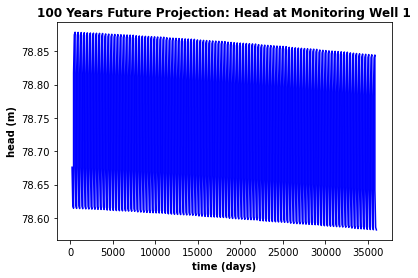

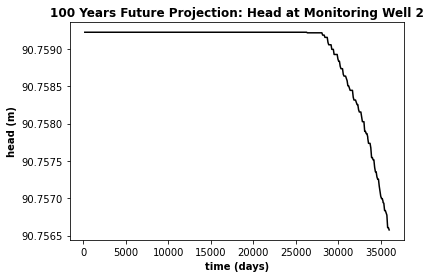

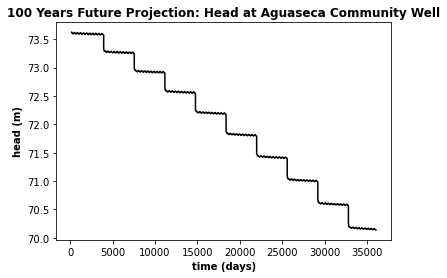

In [17]:
#create plot of MW1
plt.subplot(1, 1, 1)
plt.title("100 Years Future Projection: Head at Monitoring Well 1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
plt.show()

#create plot of MW2
plt.subplot(1, 1, 1)
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years Future Projection: Head at Monitoring Well 2",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series2[:, 0], time_series2[:, 1], 'k-') #plot the time series with points at each record
plt.show()

# #create plot of Ag well
# plt.subplot(1, 1, 1)
# plt.title("100 Years Future Projection: Head at the Irrigation Well",fontweight='bold')
# plt.xlabel('time (days)',fontweight='bold')
# plt.ylabel('head (m)',fontweight='bold')
# plt.plot(time_series_ag[:, 0], time_series_ag[:, 1], 'k-') #plot the time series with points at each record
# plt.show()

#create plot of Aguaseca com well
plt.subplot(1, 1, 1)
plt.title("100 Years Future Projection: Head at Aguaseca Community Well",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_agua[:, 0], time_series_agua[:, 1], 'k-') #plot the time series with points at each record
plt.show()

In [20]:
#getting initial heads
print("Final Head at Monitoring Well 2 = ", head['sp0'][0, 37, 12])
print("Final Head at Monitoring Well 1 = ", head['sp0'][0, 25, 24])
print("Final Head at Community Well 1 = ", head['sp0'][2, 29, 37])
print()



Final Head at Monitoring Well 2 =  90.75658
Final Head at Monitoring Well 1 =  78.58202
Final Head at Community Well 1 =  70.13852



## Saving final head array scen4

In [ ]:
from numpy import asarray
from numpy import savetxt
#print(head.keys())

head_top = head['sp%s'%(len(head)-1)][0,:,:]
head_mid = head['sp%s'%(len(head)-1)][1,:,:]
head_bot = head['sp%s'%(len(head)-1)][2,:,:]

savetxt('top_head_future_100yr.csv', head_top, delimiter=',')
savetxt('mid_head_future_100yr.csv', head_mid, delimiter=',')
savetxt('bot_head_future_100yr.csv', head_bot, delimiter=',')